In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor, Pool, cv

from hyperopt import fmin, hp, tpe, STATUS_OK, STATUS_FAIL, Trials
import pickle
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [40]:
tax = gpd.read_feather('../data/tax.geofeather')

In [41]:
tax['x'] = tax.geometry.centroid.x
tax['y'] = tax.geometry.centroid.y

In [42]:
X = tax.drop(['property_location', 'block', 'lot', 'parcel_number', 
              'assessor_neighborhood', 'assessor_neighborhood_district', 
              'analysis_neighborhood', 
              'supervisor_district_2012', 'supervisor_district'], 
             axis=1)

In [43]:
X['assessed_sales_value'] = X['imputed_land_value'] + X['assessed_fixtures_value'] + X['assessed_improvement_value']


In [59]:
X.current_sales_date

0                NaT
1                NaT
2                NaT
3                NaT
4                NaT
             ...    
3086505   2003-04-30
3086506   2004-07-13
3086507          NaT
3086508   2015-03-05
3086509   2016-09-29
Name: current_sales_date, Length: 3086855, dtype: datetime64[ns]

In [6]:
fmv = X[(X.year_property_built >= (X.closed_roll_year - 1)) | (X.current_sales_date.dt.year >= (tax.closed_roll_year - 1))].copy()
fmv = fmv[fmv['assessed_sales_value'] > 0]
fmv = fmv.sort_values(['assessed_sales_value'], ascending=False).drop_duplicates(['year_property_built', 'current_sales_date', 'geometry'])

In [7]:
fmv = fmv.drop(columns=['current_sales_date', 'geometry'])

In [8]:
X['assessed_sales_value'].mean()

1035241.3938629171

In [9]:
fmv['assessed_sales_value'].mean()

2688731.003061709

In [10]:
fmv['assessed_sales_value'].min()

1.0

In [11]:
fmv = fmv.drop(columns=['assessed_land_value', 'assessed_fixtures_value', 'assessed_improvement_value', 'assessed_personal_property_value'])
fmv.shape

(99496, 30)

In [84]:
X_fmv = fmv.drop(columns='assessed_sales_value')
y_fmv = np.log(fmv['assessed_sales_value'])

In [85]:
cat_indices = np.where(X_fmv.dtypes == 'object')[0]

In [87]:
train_pool = Pool(data=X_fmv, label=y_fmv, cat_features=cat_indices)

def hyperopt_objective(params):
    print(params)
    cv_data = cv(
        params=params,
        pool=train_pool,
        fold_count=5,
        shuffle=True,
        partition_random_seed=0,
        stratified=False,
        logging_level='Silent',
        early_stopping_rounds=10
    )
    loss = cv_data['test-RMSE-mean'].min()
    return loss


# We initiate a Trial object to keep track of search results and we set a hyperparameter space
trials = Trials()
space = {
    "iterations": 1000,
    'loss_function': 'RMSE',
    'learning_rate': hp.uniform('learning_rate', 0.25, 0.5),
    'depth': hp.randint('depth', 2, 10),
    'l2_leaf_reg': hp.loguniform('l2_leaf_reg', -5, 5),
    'border_count': hp.randint('border_count', 10, 255),
    'subsample': hp.uniform('subsample', 0.25, .75),
    'boosting_type': hp.choice('boosting_type', ['Ordered', 'Plain']),
}

# We finally use fmin to perform the search
'''
best = fmin(hyperopt_objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            rstate=np.random.default_rng(42),
            trials=trials)
'''
print()

In [15]:
best

{'boosting_type': 1,
 'border_count': 182,
 'depth': 3,
 'l2_leaf_reg': 2.5206936794284682,
 'learning_rate': 0.30305427924833384,
 'subsample': 0.4518888351309896}

In [88]:
best = {'boosting_type': 1,
 'border_count': 182,
 'depth': 3,
 'l2_leaf_reg': 2.5206936794284682,
 'learning_rate': 0.30305427924833384,
 'subsample': 0.4518888351309896}

In [89]:
best['boosting_type'] = 'Ordered' if best.get('boosting_type') == 0 else 'Plain'

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
r2_scores = []

for train_index, test_index in kf.split(X_fmv):
    X_train_r, X_test_r = X_fmv.iloc[train_index], X_fmv.iloc[test_index]
    y_train_r, y_test_r = y_fmv.iloc[train_index], y_fmv.iloc[test_index]

    train_dataset_r = Pool(data=X_train_r, label=y_train_r,  cat_features=cat_indices)
    test_dataset_r = Pool(data=X_test_r, label=y_test_r,  cat_features=cat_indices)

    model_r = CatBoostRegressor(iterations=1000, loss_function='RMSE', random_seed=0, verbose=1, **best)
    model_r.fit(train_dataset_r, verbose=0)

    predictions_r = model_r.predict(test_dataset_r)
    r2 = r2_score(y_test_r, predictions_r)
    r2_scores.append(r2)
r2_scores

[0.9784461401138946,
 0.9733501054538772,
 0.9760272356838665,
 0.9766343203615577,
 0.976591335175723]

In [ ]:
r2_scores = [0.9784461401138946,
 0.9733501054538772,
 0.9760272356838665,
 0.9766343203615577,
 0.976591335175723]

In [19]:
sum(r2_scores) / 5

0.9762098273577837

In [20]:
pickle.dump(trials, open("my_trials_fmv.pkl", "wb"))

with open("my_trials_fmv.pkl", "rb") as f:
    object = pickle.load(f)

df_trials = pd.DataFrame(object)
df_trials.to_csv(r'catboost_results_fmv.csv')

In [90]:
catboostFinal = CatBoostRegressor(**best, loss_function='RMSE', random_seed=0, iterations=1000)

In [91]:
catboostFinal.fit(train_pool)

0:	learn: 0.8560010	total: 26.7ms	remaining: 26.7s
1:	learn: 0.6726434	total: 52.5ms	remaining: 26.2s
2:	learn: 0.5477644	total: 79.8ms	remaining: 26.5s
3:	learn: 0.4558346	total: 104ms	remaining: 26s
4:	learn: 0.3930084	total: 127ms	remaining: 25.2s
5:	learn: 0.3491360	total: 152ms	remaining: 25.1s
6:	learn: 0.3184246	total: 179ms	remaining: 25.4s
7:	learn: 0.2978751	total: 203ms	remaining: 25.2s
8:	learn: 0.2829509	total: 227ms	remaining: 25s
9:	learn: 0.2726688	total: 252ms	remaining: 25s
10:	learn: 0.2658524	total: 279ms	remaining: 25.1s
11:	learn: 0.2597834	total: 305ms	remaining: 25.1s
12:	learn: 0.2550088	total: 328ms	remaining: 24.9s
13:	learn: 0.2514437	total: 350ms	remaining: 24.6s
14:	learn: 0.2484153	total: 373ms	remaining: 24.5s
15:	learn: 0.2447663	total: 397ms	remaining: 24.4s
16:	learn: 0.2427068	total: 420ms	remaining: 24.3s
17:	learn: 0.2407612	total: 444ms	remaining: 24.2s
18:	learn: 0.2390705	total: 468ms	remaining: 24.1s
19:	learn: 0.2372199	total: 496ms	remaining:

In [92]:
X = tax.drop(columns = 
             ['property_location', 'block', 'lot', 'parcel_number', 
              'assessor_neighborhood', 'assessor_neighborhood_district', 
              'analysis_neighborhood',
              'supervisor_district_2012', 'supervisor_district', 'geometry', 
              'current_sales_date', 
              'assessed_land_value',
              'assessed_fixtures_value',
              'assessed_improvement_value', 
              'assessed_personal_property_value'])


In [93]:
predictions = catboostFinal.predict(X)

In [94]:
np.exp(predictions.min())

1.1566639351028505

In [99]:
tax['imputed_fair_market_acquisition'] = np.exp(predictions)

In [100]:
tax.loc[fmv.index, 'imputed_fair_market_acquisition'].sample(10, random_state=0)

2112847    7.503294e+05
1833503    9.342469e+05
1446025    6.023285e+05
877335     4.714329e+05
2040532    9.593567e+05
2171399    7.420494e+05
2698487    2.112630e+06
2912976    1.218674e+06
2767982    9.884089e+04
2282802    6.232055e+04
Name: imputed_fair_market_acquisition, dtype: float64

In [101]:
tax.loc[fmv.index, 'imputed_fair_market_acquisition'] = fmv['assessed_sales_value']

In [102]:
tax.loc[fmv.index, 'imputed_fair_market_acquisition'].sample(10, random_state=0)

2112847    7.400000e+05
1833503    8.100000e+05
1446025    6.375000e+05
877335     2.683315e+05
2040532    9.280000e+05
2171399    7.430000e+05
2698487    2.050000e+06
2912976    1.225000e+06
2767982    1.028810e+05
2282802    4.575700e+04
Name: imputed_fair_market_acquisition, dtype: float64

In [103]:
tax[tax['imputed_fair_market_acquisition'] == tax['imputed_fair_market_acquisition'].max()]

,property_class_code_definition,lot_code,property_area,volume_number,percent_of_ownership,misc_exemption_value,zoning_code,year_property_built,analysis_neighborhood,number_of_units,...,assessed_land_value,basement_area,assessed_improvement_value,geometry,zillow_neighborhood_name,x,y,imputed_land_value,years_since_last_sale,imputed_fair_market_acquisition
465702,Vacant land- residential 15+ units,O,124347.0,25.0,1.0,0.0,P,2018.0,Financial District/South Beach,124.0,...,0.0,836.0,0.0,POINT (-210499.700 -22627.988),Financial District,-210499.700252,-22627.988393,8.610502e+10,NaN,8.610502e+10


In [105]:
diff = (tax['imputed_fair_market_acquisition'] - (tax['assessed_land_value'] + tax['assessed_improvement_value'] + tax['assessed_fixtures_value']))

In [106]:
diff.describe()

count    3.086855e+06
mean     9.552257e+04
std      4.922090e+07
min     -1.651988e+09
25%     -4.522661e+03
50%      2.930861e+04
75%      1.117471e+05
max      8.610502e+10
dtype: float64

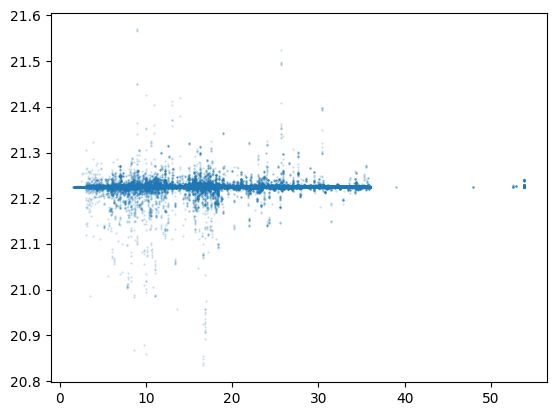

In [123]:
plt.scatter(tax['years_since_last_sale'], np.log((abs(diff.min()) + diff)), alpha=.25, s=.25)

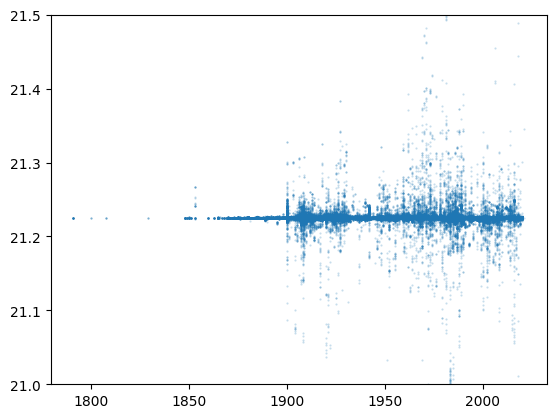

In [122]:
plt.scatter(tax['year_property_built'], np.log1p((abs(diff.min()) + diff)), alpha=.25, s=.25)
plt.ylim((21, 21.5))
plt.show()

In [36]:
tax.sort_values('imputed_fair_market_acquisition', ascending=True)

,property_class_code_definition,lot_code,property_area,volume_number,percent_of_ownership,misc_exemption_value,zoning_code,year_property_built,analysis_neighborhood,number_of_units,...,assessed_land_value,basement_area,assessed_improvement_value,geometry,zillow_neighborhood_name,x,y,imputed_land_value,years_since_last_sale,imputed_fair_market_acquisition
2701519,Vacant Lot - Restrictions,NA,0.0,40.0,NaN,0.0,RH1,NaN,Outer Mission,0.0,...,0.0,0.0,0.000000e+00,POINT (-214255.424 -29068.547),Outer Mission,-214255.423595,-29068.546512,5.135027e+01,NaN,8.851891e-01
2704190,Vacant Lot - Restrictions,NA,0.0,40.0,NaN,0.0,RH2,NaN,West of Twin Peaks,0.0,...,0.0,0.0,0.000000e+00,POINT (-214775.592 -28863.972),Outer Mission,-214775.591801,-28863.972164,3.241978e+01,NaN,9.148448e-01
2713235,Vacant Lot - Restrictions,NA,0.0,42.0,NaN,0.0,RH1,NaN,Outer Mission,0.0,...,0.0,0.0,0.000000e+00,POINT (-215617.435 -30710.843),Outer Mission,-215617.434835,-30710.842658,3.143088e+01,NaN,9.242261e-01
2709598,Vacant Lot - Restrictions,NA,0.0,42.0,NaN,0.0,RH1,NaN,Outer Mission,0.0,...,0.0,0.0,0.000000e+00,POINT (-215559.212 -30663.382),Outer Mission,-215559.211853,-30663.381947,3.143088e+01,NaN,9.242261e-01
2711132,Vacant Lot - Restrictions,NA,0.0,42.0,NaN,0.0,RH1,NaN,Outer Mission,0.0,...,0.0,0.0,0.000000e+00,POINT (-215080.653 -30319.423),Outer Mission,-215080.653333,-30319.423029,3.242856e+01,NaN,9.251364e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448137,Office,R,1420430.0,25.0,1.0,0.0,C3OSD,2018.0,Financial District/South Beach,0.0,...,211747199.0,0.0,1.479998e+09,POINT (-210762.748 -22516.193),Financial District,-210762.747553,-22516.192853,2.117472e+08,9.768652,1.691745e+09
2638896,Office,R,1420430.0,25.0,1.0,0.0,C3OSD,2018.0,Financial District/South Beach,0.0,...,218219716.0,0.0,1.583330e+09,POINT (-210762.748 -22516.193),Financial District,-210762.747553,-22516.192853,2.182197e+08,9.768652,1.700999e+09
1238901,Office,R,1420430.0,25.0,1.0,0.0,C3OSD,2018.0,Financial District/South Beach,0.0,...,215982142.0,0.0,1.567095e+09,POINT (-210762.748 -22516.193),Financial District,-210762.747553,-22516.192853,2.159821e+08,9.768652,1.700999e+09
1142808,Hospitals,R,1015000.0,5.0,1.0,691737757.0,RC4,2019.0,Western Addition,0.0,...,73531026.0,0.0,1.663416e+09,POINT (-213019.407 -22883.233),Western Addition,-213019.406713,-22883.232908,7.353103e+07,NaN,2.606239e+09


In [37]:
tax.to_feather('../data/fair_market_acquisition.geofeather')